# Usage example: Autism classification

This example uses data from 20 participants of the [Autism Brain Imaging Data Exchange (ABIDE)](http://preprocessed-connectomes-project.org/abide/) preprocessed connectomes dataset. The goal is to predict an autism diagnosis from static functional connectivity estimates. Please note that the results are not valid due to the many statistical issues when performing prediction with only 20 observations and tens of thousands of features.

The multiverse is is similar to the one perfomed by [Dafflon et al. 2022](https://www.nature.com/articles/s41467-022-31347-8) with the main difference being the use of only 20 participants and two connectivity methods to reduce memory and cpu load. 

## Data Download

For simplicity, the data is accessed through [nilearn](https://nilearn.github.io/dev/modules/generated/nilearn.datasets.fetch_abide_pcp.html). The download will take around 15-20 minutes (48 iterations).

In [8]:
from tqdm import tqdm
import itertools
from nilearn import datasets
from matplotlib import pyplot as plt

pipeline = ["cpac", "ccs", "dparsf", "niak"]                    # Preprocessing pipelines
band_pass = [True, False]                                       # Band-pass filtering   
global_signal = [True, False]                                   # Global signal regression 
parcellation = ["rois_aal", "rois_cc200", "rois_dosenbach160"]  # Parcellated time series data

# Download the ABIDE dataset with all combinations of the decision points
abide_dataset = {} # store in a dict (only needed to print some information at the end of this cell)
for pipe, bp, gsr, parc in tqdm(itertools.product(pipeline, band_pass, global_signal, parcellation)):
    bunch = datasets.fetch_abide_pcp(
        SUB_ID=[50012, 50014, 50015, 50016, 50020, 50022, 50023, 50024, 50025, 50027,
                50030, 50031, 50032, 50033, 50034, 50035, 50036, 50037, 50038, 50040],
        data_dir="./abide_data", verbose=0,
        pipeline=pipe, derivatives=parc, band_pass_filtering=bp, global_signal_regression=gsr)
    abide_dataset[(pipe, bp, gsr, parc)] = bunch

print(f"Available pipelines: {list(abide_dataset.keys())}")
print(f"Number of subjects:  {len(abide_dataset[('cpac', True, True, 'rois_aal')].phenotypic)}")
print(f"Class distribution:  {abide_dataset[('cpac', True, True, 'rois_aal')].phenotypic['DX_GROUP'].value_counts()}")

48it [00:06,  7.95it/s]

Available pipelines: [('cpac', True, True, 'rois_aal'), ('cpac', True, True, 'rois_cc200'), ('cpac', True, True, 'rois_dosenbach160'), ('cpac', True, False, 'rois_aal'), ('cpac', True, False, 'rois_cc200'), ('cpac', True, False, 'rois_dosenbach160'), ('cpac', False, True, 'rois_aal'), ('cpac', False, True, 'rois_cc200'), ('cpac', False, True, 'rois_dosenbach160'), ('cpac', False, False, 'rois_aal'), ('cpac', False, False, 'rois_cc200'), ('cpac', False, False, 'rois_dosenbach160'), ('ccs', True, True, 'rois_aal'), ('ccs', True, True, 'rois_cc200'), ('ccs', True, True, 'rois_dosenbach160'), ('ccs', True, False, 'rois_aal'), ('ccs', True, False, 'rois_cc200'), ('ccs', True, False, 'rois_dosenbach160'), ('ccs', False, True, 'rois_aal'), ('ccs', False, True, 'rois_cc200'), ('ccs', False, True, 'rois_dosenbach160'), ('ccs', False, False, 'rois_aal'), ('ccs', False, False, 'rois_cc200'), ('ccs', False, False, 'rois_dosenbach160'), ('dparsf', True, True, 'rois_aal'), ('dparsf', True, True, 'ro

## Create and run the multiverse

Available decision points for the preprocessed fMRI time series data are the following:

- Preprocessing pipeline (`'cpac'`, `'ccs'`, `'dparsf'`, `'niak'`)
- Band pass filtering (`True` or `False`)
- Global signal regression (`True` or `False`) -> If false, standard motion regression was performed
- Parcellation atlas (`'rois_aal'`, `'rois_cc200'`, `'rois_dosenbach160'`)

For the connectivity measure, the two methods from the comet toolbox are already included:

- Pearson correlation (`comet.connectivity.Static_Pearson`)
- Partial correlation (`comet.connectivity.Static_Partial`)

In [ ]:
from comet import multiverse

forking_paths = {
    "pipeline": ["'cpac'", "'ccs'", "'dparsf'", "'niak'"],                  # Preprocessing pipelines
    "parcellation": ["'rois_aal'", "'rois_cc200'", "'rois_dosenbach160'"],  # Parcellated time series data
    "band_pass": [True, False],                                             # Band-pass filtering   
    "global_signal": [True, False],                                         # Global signal regression     
    "connectivity":[                                                        # Functional connectivity method
        {"name": "pearson", "func": "comet.connectivity.Static_Pearson(ts).estimate()"},
        {"name": "partial", "func": "comet.connectivity.Static_Partial(ts).estimate()"}]
}

def analysis_template():
    import comet
    import numpy as np
    from nilearn import datasets
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import StratifiedKFold, cross_val_score

    # Get data (if it is preloaded the download is skipped)
    data = datasets.fetch_abide_pcp(SUB_ID=[50012, 50014, 50015, 50016, 50020, 50022, 50023, 50024, 50025, 50027,
                                            50030, 50031, 50032, 50033, 50034, 50035, 50036, 50037, 50038, 50040],
                                    data_dir="./abide_data", verbose=0, 
                                    pipeline={{pipeline}},
                                    derivatives={{parcellation}},
                                    band_pass_filtering={{band_pass}},
                                    global_signal_regression={{global_signal}})

    time_series = data[{{parcellation}}]
    diagnosis = data["phenotypic"]["DX_GROUP"]

    # Calculate FC
    tri_ix = None
    features = []

    for ts in time_series:
        FC = {{connectivity}}

        if tri_ix == None:
            tri_ix = np.triu_indices_from(FC, k=1)
        
        feat_vec = FC[tri_ix]
        features.append(feat_vec)

    # Prepare features (FC estimates) and target (autism/control)
    X = np.vstack(features)
    X[np.isnan(X)] = 0.0
    y = np.array(diagnosis)

    # Classification model
    model = Pipeline([('scaler', StandardScaler()), ('reg', LogisticRegression(penalty='l2'))])
    cv = StratifiedKFold(n_splits=5)
    accuracies = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

    # Save the results
    comet.utils.save_universe_results({"accuracy": accuracies})

# Create and run the multiverse analysis
mverse = multiverse.Multiverse(name="example_mv_abide")
mverse.create(analysis_template, forking_paths)
mverse.run(parallel=8)

,Universe,Decision 1,Value 1,Decision 2,Value 2,Decision 3,Value 3,Decision 4,Value 4,Decision 5,Value 5
0,Universe_1,pipeline,'cpac',parcellation,'rois_aal',band_pass,True,global_signal,True,connectivity,pearson
1,Universe_2,pipeline,'cpac',parcellation,'rois_aal',band_pass,True,global_signal,True,connectivity,partial
2,Universe_3,pipeline,'cpac',parcellation,'rois_aal',band_pass,True,global_signal,False,connectivity,pearson
3,Universe_4,pipeline,'cpac',parcellation,'rois_aal',band_pass,True,global_signal,False,connectivity,partial
4,Universe_5,pipeline,'cpac',parcellation,'rois_aal',band_pass,False,global_signal,True,connectivity,pearson
...,...,...,...,...,...,...,...,...,...,...,...
91,Universe_92,pipeline,'niak',parcellation,'rois_dosenbach160',band_pass,True,global_signal,False,connectivity,partial
92,Universe_93,pipeline,'niak',parcellation,'rois_dosenbach160',band_pass,False,global_signal,True,connectivity,pearson
93,Universe_94,pipeline,'niak',parcellation,'rois_dosenbach160',band_pass,False,global_signal,True,connectivity,partial
94,Universe_95,pipeline,'niak',parcellation,'rois_dosenbach160',band_pass,False,global_signal,False,connectivity,pearson


/home/mibur/miniconda3/envs/dfc-multiverse/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


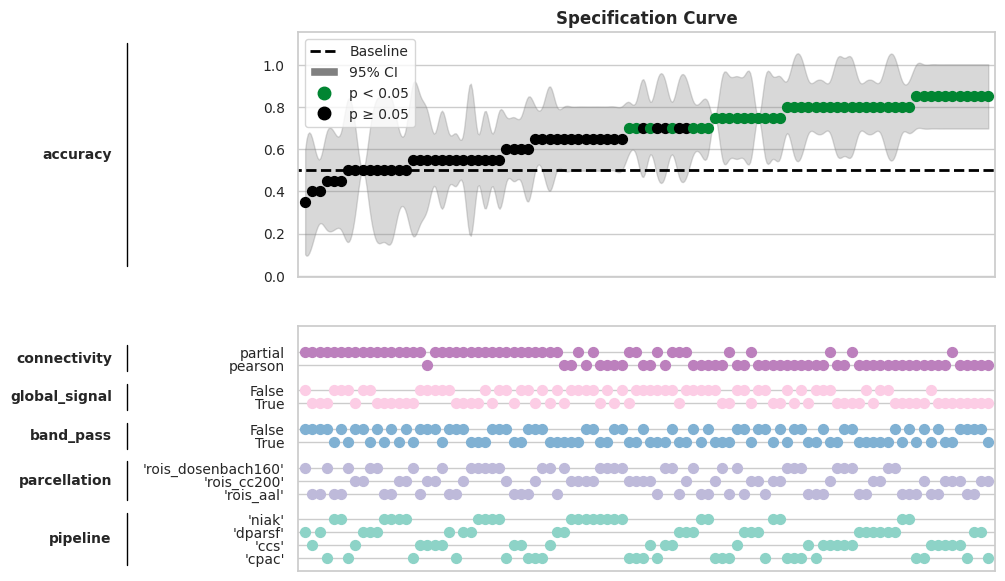

In [12]:
mverse.summary()
mverse.specification_curve("accuracy", height_ratio=(1,1), figsize=(9,7), baseline=0.5, ci=95, p_value=0.05, line_pad=0.1)